#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Higher order finite difference methods

## Lagrange Interpolating Polynomials

Suppose we are given function values $u_0, \dotsc, u_n$ at the distinct points $x_0, \dotsc, x_n$ and we would like to build a polynomial of degree $n$ that goes through all these points.  This explicit construction is attributed to Lagrange (though he was not first):

$$ p(x) = \sum_{i=0}^n u_i \prod_{j \ne i} \frac{x - x_j}{x_i - x_j} $$

* What is the degree of this polynomial?
* Why is $p(x_i) = u_i$?
* How expensive (in terms of $n$) is it to evaluate $p(x)$?
* How expensive (in terms of $n$) is it to convert to standard form $p(x) = \sum_{i=0}^n a_i x^i$?
* Can we easily evaluate the derivative $p'(x)$?
* What can go wrong?  Is this formulation numerically stable?

A general derivation of finite difference methods for approximating $p^{(k)}(x)$ using function values $u(x_i)$ is to construct the Lagrange interpolating polynomial $p(x)$ from the function values $u_i = u(x_i)$ and evaluate it or its derivatives at the target point $x$.  We can do this directly from the formula above, but a more linear algebraic approach will turn out to be more reusable.

#### Uniqueness

Is the polynomial $p(x)$ of degree $m$ that interpolates $m+1$ points unique?  Why?

### Vandermonde matrices

We can compute a polynomial

$$ p(x) = c_0 + c_1 x + c_2 x^2 + \dotsb $$

that assumes function values $p(x_i) = u_i$ by solving a linear system with the Vandermonde matrix.

$$ \underbrace{\begin{bmatrix} 1 & x_0 & x_0^2 & \dotsb \\
    1 & x_1 & x_1^2 & \dotsb \\
    1 & x_2 & x_2^2 & \dotsb \\
    \vdots & & & \ddots \end{bmatrix}}_V \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ \vdots \end{bmatrix} = \begin{bmatrix} u_0 \\ u_1 \\ u_2 \\ \vdots \end{bmatrix} .$$

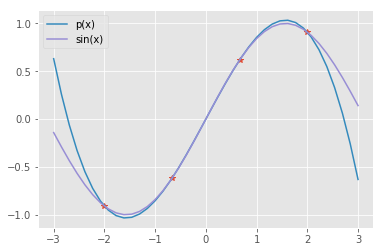

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

x = numpy.linspace(-2,2,4)
u = numpy.sin(x)
xx = numpy.linspace(-3,3,40)
c = numpy.linalg.solve(numpy.vander(x), u)
pyplot.plot(x, u, '*')
pyplot.plot(xx, numpy.vander(xx, 4).dot(c), label='p(x)')
pyplot.plot(xx, numpy.sin(xx), label='sin(x)')
pyplot.legend(loc='upper left');

Given the coefficients $c = V^{-1} u$, we find

$$ \begin{align} p(0) &= c_0 \\ p'(0) &= c_1 \\ p''(0) &= c_2 \cdot 2! \\ p^{(k)}(0) &= c_k \cdot k! . \end{align} $$

To compute the stencil coefficients $s_i^0$ for interpolation to $x=0$,
$$ p(0) = s_0^0 u_0 + s_1^0 u_1 + \dotsb = \sum_i s_i^0 u_i $$
we can write
$$ p(0) = e_0^T \underbrace{V^{-1} u}_c = \underbrace{e_0^T V^{-1}}_{(s^0)^T} u $$
where $e_0$ is the first column of the identity.  Evidently $s^0$ can also be expressed as
$$ s^0 = V^{-T} e_0 . $$
We can compute stencil coefficients for any order derivative $p^{(k)}(0) = (s^k)^T u$ by solving the linear system
$$ s^k = V^{-T} e_k \cdot k! . $$
Alternatively, invert the Vandermonde matrix $V$ and scale row $k$ of $V^{-1}$ by $k!$.

[[ 1.          0.          0.          0.        ]
 [-1.83333333  3.         -1.5         0.33333333]
 [ 2.         -5.          4.         -1.        ]
 [-1.          3.         -3.          1.        ]]


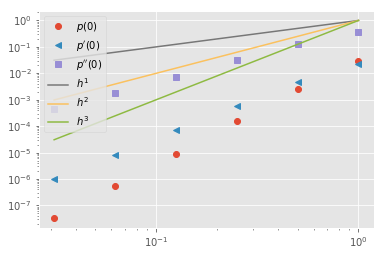

In [2]:
def fdstencil(z, x):
    x = numpy.array(x)
    V = numpy.vander(x - z, increasing=True)
    scaling = numpy.array([numpy.math.factorial(i) for i in range(len(x))])
    return (numpy.linalg.inv(V).T * scaling).T

x = numpy.linspace(0,3,4)
S = fdstencil(0, x)
print(S)

hs = 2.**(-numpy.arange(6))
errors = numpy.zeros((3,len(hs)))
for i,h in enumerate(hs):
    z = 1 + .3*h
    S = fdstencil(z, 1+x*h)
    u = numpy.sin(1+x*h)
    errors[:,i] = S[:3].dot(u) - numpy.array([numpy.sin(z), numpy.cos(z), -numpy.sin(z)])

pyplot.loglog(hs, numpy.abs(errors[0]), 'o', label="$p(0)$")
pyplot.loglog(hs, numpy.abs(errors[1]), '<', label="$p'(0)$")
pyplot.loglog(hs, numpy.abs(errors[2]), 's', label="$p''(0)$")
for k in (1,2,3):
    pyplot.loglog(hs, hs**k, label='$h^{%d}$' % k)
pyplot.legend(loc='upper left');

### Notes on accuracy

* When using three points, we fit a polynomial of degree 2.  The leading error term for interpolation $p(0)$ is thus $O(h^3)$.
* Each derivative gives up one order of accuracy, therefore differencing to a general (non-centered or non-uniform grid) point is $O(h^2)$ for the first derivative and $O(h)$ for the second derivative.
* Centered differences on uniform grids can provide cancelation, raising the order of accuracy by one.  So our standard 3-point centered second derivative is $O(h^2)$ as we have seen in the Taylor analysis and numerically.
* The Vandermonde matrix is notoriously ill-conditioned when using many points.  For such cases, we recommend using a more numerically stable method from [Fornberg](https://doi.org/10.1137/S0036144596322507).

In [3]:
-fdstencil(0, numpy.linspace(-1,4,6))[2]

array([-0.83333333,  1.25      ,  0.33333333, -1.16666667,  0.5       ,
       -0.08333333])

### Solving BVPs

This `fdstencil` gives us a way to compute derivatives of arbitrary accuracy on arbitrary grids.  We will need to use uncentered rules near boundaries, usually with more points to maintain order of accuracy.  This will usually cost us symmetry.  Implementation of boundary conditions is the bane of high order finite difference methods.

### Discretization stability measures: $h$-ellipticity

Consider the test function $\phi(\theta, x) = e^{i\theta x}$ and apply the difference stencil centered at an arbitrary point $x$ with element size $h=1$:

$$ \begin{bmatrix} -1 & 2 & -1 \end{bmatrix} \begin{bmatrix} e^{i \theta (x - 1)} \\ e^{i \theta x} \\ e^{i \theta (x+1)} \end{bmatrix}
= \big( 2 - (e^{i\theta} + e^{-i\theta}) \big) e^{i\theta x}= 2 (1 - \cos \theta) e^{i \theta x} . $$

Evidently $\phi(\theta,x) = e^{i \theta x}$ is an eigenfunction of the discrete differencing operator on an infinite grid and the corresponding eigenvalue is
$$ L(\theta) = 2 (1 - \cos \theta), $$
also known as the "symbol" of the operator.  That $\phi(\theta,x)$ is an eigenfunction of the discrete differencing formula will generally be true for uniform grids.

The highest frequency that is distinguishable using this stencil is $\theta_{\max} = \pi$ which results in a wave at the Nyquist frequency.  If a higher frequency wave is sampled onto this grid, it will be aliased back into the interval $[-\pi, \pi)$.

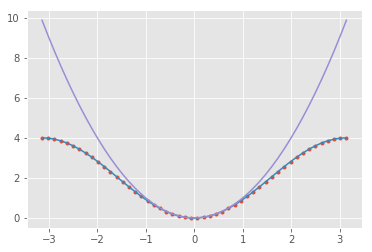

In [4]:
x = numpy.linspace(-1, 1, 3)
s2 = -fdstencil(0, x)[2]
theta = numpy.linspace(-numpy.pi, numpy.pi)
phi = numpy.exp(1j*numpy.outer(x, theta))
pyplot.plot(theta, numpy.abs(s2.dot(phi)), '.')
pyplot.plot(theta, 2*(1-numpy.cos(theta)))
pyplot.plot(theta, theta**2);

A measure of internal stability known as $h$-ellipticity is defined by

$$ E^h(L) = \frac{\min_{\pi/2 \le |\theta| \le \pi} L(\theta)}{\max_{|\theta| \le \pi} L(\theta)} . $$

* What is $E^h(L)$ for the second order "version 2" stencil?
* How about for uncentered formulas and higher order?

# Spectral collocation

Suppose that instead of using only a fixed number of neighbors in our differencing stencil, we use all points in the domain?

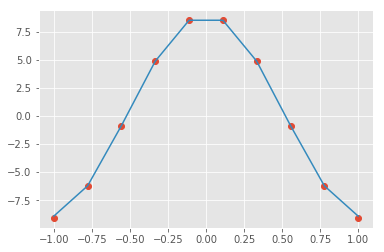

In [5]:
n = 10
x = numpy.linspace(-1, 1, n)
L = numpy.zeros((n,n))
for i in range(n):
    L[i] = -fdstencil(x[i], x)[2]

u = numpy.cos(3*x)
pyplot.plot(x, L.dot(u), 'o')
pyplot.plot(x, 9*u);

We are suffering from two problems here.  The first is that the monomial basis is very ill-conditioned when using many terms.  This is true as continuous functions, not just when sampled onto a particular grid.

95176.85951858871

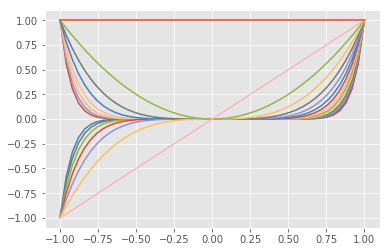

In [6]:
x = numpy.linspace(-1, 1, 50)
V = numpy.vander(x, 15)
pyplot.plot(x, V)
numpy.linalg.cond(V)

## Chebyshev polynomials

Define $$ T_n(x) = \cos (n \arccos(x)) .$$
This turns out to be a polynomial, though it may not be obvious why.
Recall $$ \cos(a + b) = \cos a \cos b - \sin a \sin b .$$
Let $y = \arccos x$ and check
$$ \begin{split}
    T_{n+1}(x) &= \cos (n+1) y = \cos ny \cos y - \sin ny \sin y \\
    T_{n-1}(x) &= \cos (n-1) y = \cos ny \cos y + \sin ny \sin y
\end{split}$$
Adding these together produces a similar recurrence:
$$\begin{split}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n+1}(x) &= 2 x T_n(x) - T_{n-1}(x)
\end{split}$$
which we can also implement in code

2.2175074843646954

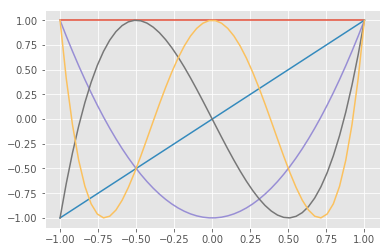

In [26]:
def vander_chebyshev(x, n=None):
    if n is None:
        n = len(x)
    T = numpy.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(2,n):
        T[:,k] = 2 * x * T[:,k-1] - T[:,k-2]
    return T

x = numpy.linspace(-1, 1)
V = vander_chebyshev(x, 5)
pyplot.plot(x, V)
numpy.linalg.cond(V)

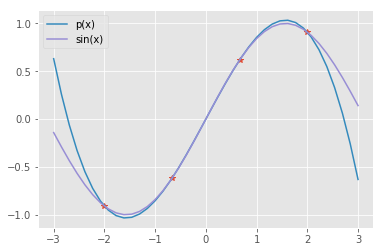

In [8]:
# We can use the Chebyshev basis for interpolation
x = numpy.linspace(-2, 2, 4)
u = numpy.sin(x)
c = numpy.linalg.solve(vander_chebyshev(x), u)
pyplot.plot(x, u, '*')
pyplot.plot(xx, vander_chebyshev(xx, 4).dot(c), label='p(x)')
pyplot.plot(xx, numpy.sin(xx), label='sin(x)')
pyplot.legend(loc='upper left');

### Differentiation

We can differentiate Chebyshev polynomials using the recurrence

$$ \frac{T_n'(x)}{n} = 2 T_{n-1}(x) + \frac{T_{n-2}'(x)}{n-2} $$

which we can differentiate to evaluate higher derivatives.

cond = 2.739109e+10


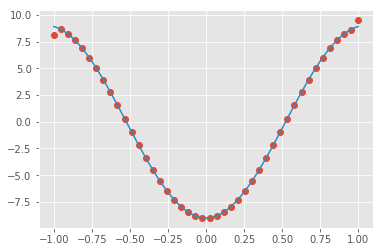

In [9]:
def chebeval(z, n=None):
    """Build matrices to evaluate the n-term Chebyshev expansion and its derivatives at point(s) z"""
    z = numpy.array(z, ndmin=1)
    if n is None:
        n = len(z)
    Tz = vander_chebyshev(z, n)
    dTz = numpy.zeros_like(Tz)
    dTz[:,1] = 1
    dTz[:,2] = 4*z
    ddTz = numpy.zeros_like(Tz)
    ddTz[:,2] = 4
    for n in range(3,n):
        dTz[:,n]  = n * (2*Tz[:,n-1] + dTz[:,n-2]/(n-2))
        ddTz[:,n] = n * (2*dTz[:,n-1] + ddTz[:,n-2]/(n-2))
    return [Tz, dTz, ddTz]

n = 44
x = numpy.linspace(-1, 1, n)
T = vander_chebyshev(x)
print('cond = {:e}'.format(numpy.linalg.cond(T)))
Tinv = numpy.linalg.inv(T)
L = numpy.zeros((n,n))
for i in range(n):
    L[i] = chebeval(x[i], n)[2].dot(Tinv)

u = numpy.cos(3*x)
pyplot.plot(x, L.dot(u), 'o')
xx = numpy.linspace(-1, 1, 100)
pyplot.plot(xx, -9*numpy.cos(3*xx));

### Runge Effect

Polynomial interpolation on equally spaced points is very ill-conditioned as the number of points grows.  We've seen that in the growth of the condition number of the Vandermonde matrix, both for monomials and Chebyshev polynomials, but it's also true if the polynomials are measured in a different norm, such as pointwise values or merely the eyeball norm.

A (20, 20)
B (100, 20)


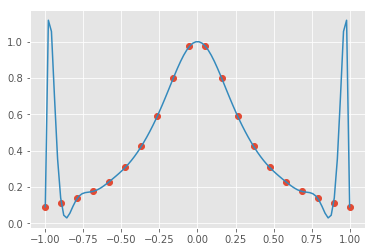

In [25]:
def chebyshev_interp_and_eval(x, xx):
    """Matrix mapping from values at points x to values
    of Chebyshev interpolating polynomial at points xx"""
    
    # Set up a Vandermonde matrix, featuring Chebychev terms
    # evaluated at the points in x.
    A = vander_chebyshev(x)
    
    # Set up another Vandermond matrix with the same Chebychev
    # polynomials, but evaluate them at the points in xx. We expect 
    # xx to have more terms, so B would have more rows than A.
    B = vander_chebyshev(xx, len(x))
    
    # Returns a matrix to multiply with a len(x) vector of function 
    # values. It creates an interpolating polynomial between those 
    # values and evaluates that polynomial at the points in xx
    # for the purpose of plotting the interpolating function nicely
    # against the reference points.
    return B.dot(numpy.linalg.inv(A))

def runge1(x):
    return 1 / (1 + 10*x**2)
x = numpy.linspace(-1,1,20)
xx = numpy.linspace(-1,1,100)
pyplot.plot(x, runge1(x), 'o')

pyplot.plot(xx, chebyshev_interp_and_eval(x, xx).dot(runge1(x)));

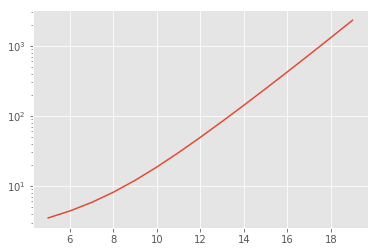

In [11]:
ns = numpy.arange(5,20)
conds = [numpy.linalg.cond(chebyshev_interp_and_eval(numpy.linspace(-1,1,n),
                                                    numpy.linspace(-1,1,100)))
        for n in ns]
pyplot.semilogy(ns, conds);

This ill-conditioning cannot be fixed when using polynomial *interpolation* on equally spaced grids.

### Chebyshev nodes

The Chebyshev polynomials assume their maximum value of 1 at points where their derivatives are zero (plus the endpoints).  Choosing the roots of $T_n'(x)$ (plus endpoints) will control the polynomials and should lead to a well-conditioned formulation.

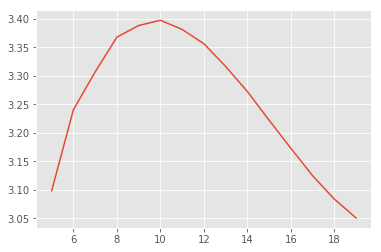

In [12]:
def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (numpy.cos(numpy.linspace(-numpy.pi, 0, n)))

conds = [numpy.linalg.cond(chebyshev_interp_and_eval(cosspace(-1,1,n),
                                                    numpy.linspace(-1,1,100)))
        for n in ns]
pyplot.figure()
pyplot.plot(ns, conds);

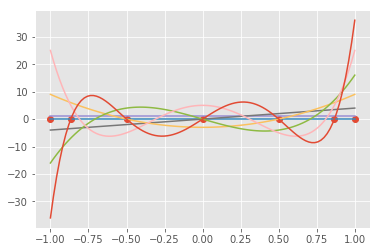

In [13]:
x = cosspace(-1, 1, 7)
pyplot.plot(x, 0*x, 'o')
pyplot.plot(xx, chebeval(xx, 7)[1]);

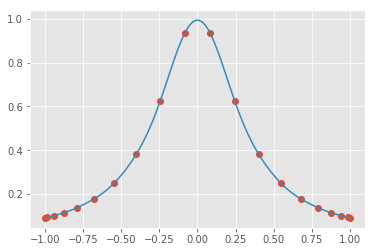

In [14]:
x = cosspace(-1,1,20)
xx = numpy.linspace(-1,1,100)
pyplot.figure()
pyplot.plot(x, runge1(x), 'o')
pyplot.plot(xx, chebyshev_interp_and_eval(x, xx).dot(runge1(x)));

## Chebyshev solution of Boundary Value Problems

If instead of an equally (or arbitrarily) spaced grid, we choose the Chebyshev nodes and compute derivatives in a stable way (e.g., via interpolating into the Chebyshev basis), we should have a very accurate method.  Let's return to our test equation

$$ -u''(x) = f(x) $$

subject to some combination of Neumann and Dirichlet boundary conditions.

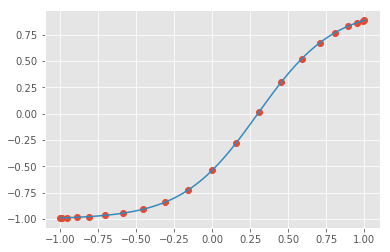

In [15]:
def laplacian_cheb(n, rhsfunc, left, right):
    """
    Solve the Laplacian boundary value problem on (-1,1) using n elements with rhsfunc(x) forcing.
    The left and right boundary conditions are specified as a pair (deriv, func) where
      * deriv=0 for Dirichlet u(x_endpoint) = func(x_endpoint)
      * deriv=1 for Neumann u'(x_endpoint) = func(x_endpoint)
    """
    x = cosspace(-1, 1, n+1)  # n+1 points is n "elements"
    
    # T[0]: chebychev expansion evaluated at points in x
    # T[1]: first derivative of chebychev expansion evaluated at points in x
    # T[2]: second derivative of chebychev expansion evaluated at points in x
    T = chebeval(x)
    
    # This is our left hand side, u''(x)
    # T[2] is the second derivative of the expansion
    L = -T[2]
    
    # Our right hand side is the forcing function f(x)
    rhs = rhsfunc(x)
    
    # Now we'll apply the boundary conditions to the first and last rows (0, 1) of the operator
    # `left` and `right` are pairs of the derivative number and the condition on it (see docstring)
    for i,deriv,func in [(0, *left), (-1, *right)]:        
        # ith row of operator L is the ith row of the derivth derivative
        L[i] = T[deriv][i]
        
        rhs[i] = func(x[i])
    
    return x, L.dot(numpy.linalg.inv(T[0])), rhs

class exact_tanh:
    def __init__(self, k=1, x0=0):
        self.k = k
        self.x0 = x0
    def u(self, x):
        return numpy.tanh(self.k*(x - self.x0))
    def du(self, x):
        return self.k * numpy.cosh(self.k*(x - self.x0))**(-2)
    def ddu(self, x):
        return -2 * self.k**2 * numpy.tanh(self.k*(x - self.x0)) * numpy.cosh(self.k*(x - self.x0))**(-2)
    
ex = exact_tanh(2, .3)
x, L, rhs = laplacian_cheb(20, lambda x: -ex.ddu(x), left=(0,ex.u), right=(1,ex.du))
pyplot.plot(x, numpy.linalg.solve(L, rhs), 'o')
pyplot.plot(xx, ex.u(xx));

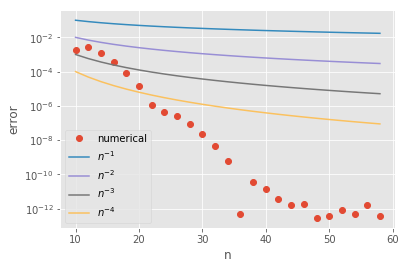

In [16]:
def mms_error(n, discretize, sol):
    x, L, f = discretize(n, lambda x: -sol.ddu(x), left=(0,sol.u), right=(1,sol.du))
    u = numpy.linalg.solve(L, f)
    return numpy.linalg.norm(u - sol.u(x), numpy.inf)

ns = numpy.arange(10,60,2)
errors = [mms_error(n, laplacian_cheb, ex) for n in ns]
pyplot.figure()
pyplot.semilogy(ns, errors, 'o', label='numerical')
for p in range(1,5):
    pyplot.semilogy(ns, 1/ns**(p), label='$n^{-%d}$'%p)
pyplot.xlabel('n')
pyplot.ylabel('error')
    
pyplot.legend(loc='lower left');

# Homework 1: Due 2017-09-25

Use a Chebyshev method to solve the second order ordinary differential equation

$$ u''(t) + a u'(t) + b u(t) = f(t) $$

from $t=0$ to $t=1$ with initial conditions $u(0) = 1$ and $u'(0) = 0$.

1. Do a grid convergence study to test the accuracy of your method.
* Setting $f(x)=0$, experiment with the values $a$ and $b$ to identify two regimes with qualitatively different dynamics.

In [23]:
Tx = chebeval(x)

print(x.shape)
Tx[0].shape

(21,)


(21, 21)